## This page uses classification models to understand the drivers of voting results.

Classification models:
- Logistic regression
- Random forest
- PCA
- other options:  support vector machine

In [25]:
# imports
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings

In [58]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
np.random.seed(42)

In [68]:
# modeling imports
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### Logistic Regression classifier, to learn feature importance.

Y = outcome of congressional vote:  
- 0 = REP, because has traditionally been the baseline.
- 1 = DEM, because this is a new trend.

#### Define X and y from voter data (can enhance with census data later on)

In [6]:
data18 = pd.read_pickle('./data/trend18.pkl')
data18.shape

(1334, 26)

In [7]:
data18.head()

,county,srprec,cddist,TOTREG,TOTVOTE,CNGDEM01,CNGREP01,election,type,totreg_r,...,nlp,grn,ref,dcl,male,female,hispdem,hisprep,hispdcl,hispoth
0,30,10316,47,1735,1278,630,592,g18,V,1238.0,...,0.0,2.0,0.0,265.0,582.0,656.0,55.0,43.0,30.0,6.0
1,30,10317,47,2079,1214,638,513,g18,V,1184.0,...,0.0,4.0,0.0,286.0,588.0,596.0,165.0,60.0,71.0,10.0
2,30,10319,47,1448,999,495,462,g18,V,945.0,...,0.0,2.0,2.0,256.0,443.0,502.0,68.0,37.0,49.0,5.0
3,30,10320,47,2407,1686,847,758,g18,V,1644.0,...,0.0,5.0,1.0,423.0,851.0,793.0,79.0,57.0,47.0,7.0
4,30,10325,47,1465,1035,488,524,g18,V,1012.0,...,0.0,2.0,1.0,189.0,488.0,524.0,67.0,38.0,18.0,1.0


In [39]:
data18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1545
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   county    1334 non-null   int64  
 1   srprec    1334 non-null   Int64  
 2   cddist    1334 non-null   int64  
 3   TOTREG    1334 non-null   int64  
 4   TOTVOTE   1334 non-null   int64  
 5   CNGDEM01  1334 non-null   int64  
 6   CNGREP01  1334 non-null   int64  
 7   election  1334 non-null   object 
 8   type      1334 non-null   object 
 9   totreg_r  1334 non-null   float64
 10  dem       1334 non-null   float64
 11  rep       1334 non-null   float64
 12  aip       1334 non-null   float64
 13  paf       1334 non-null   float64
 14  msc       1334 non-null   float64
 15  lib       1334 non-null   float64
 16  nlp       1334 non-null   float64
 17  grn       1334 non-null   float64
 18  ref       1334 non-null   float64
 19  dcl       1334 non-null   float64
 20  male      1334 non-null   floa

In [50]:
data18['election'].value_counts()
#ok to drop 'election' and 'type'

g18    1334
Name: election, dtype: int64

In [8]:
# create a categorical column where CNGREP01 > CNGDEM01

In [30]:
y_raw18 = data18[['CNGDEM01', 'CNGREP01']]
y_raw18.head()

,CNGDEM01,CNGREP01
0,630,592
1,638,513
2,495,462
3,847,758
4,488,524


In [31]:
y_raw18['dem_win'] = data18['CNGDEM01'] > data18['CNGREP01']
# will return a slice-of-dataframe warning, OK to proceed

<ipython-input-31-c685e4b1d318>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw18['dem_win'] = data18['CNGDEM01'] > data18['CNGREP01']


In [32]:
y_raw18

,CNGDEM01,CNGREP01,dem_win
0,630,592,True
1,638,513,True
2,495,462,True
3,847,758,True
4,488,524,False
...,...,...,...
1541,28,49,False
1542,93,154,False
1543,75,173,False
1544,319,784,False


In [33]:
y_raw18['dem_win'].sum()

807

In [34]:
y_raw18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1545
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CNGDEM01  1334 non-null   int64
 1   CNGREP01  1334 non-null   int64
 2   dem_win   1334 non-null   bool 
dtypes: bool(1), int64(2)
memory usage: 32.6 KB


In [35]:
y_raw18['dem_win'] = y_raw18['dem_win'].astype(int)
# will return a slice-of-dataframe warning, OK to proceed

<ipython-input-35-8b3119850fea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw18['dem_win'] = y_raw18['dem_win'].astype(int)


In [37]:
y_raw18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1545
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CNGDEM01  1334 non-null   int64
 1   CNGREP01  1334 non-null   int64
 2   dem_win   1334 non-null   int64
dtypes: int64(3)
memory usage: 41.7 KB


In [38]:
y18 = y_raw18['dem_win']

In [52]:
data18.columns.tolist()

['county',
 'srprec',
 'cddist',
 'TOTREG',
 'TOTVOTE',
 'CNGDEM01',
 'CNGREP01',
 'election',
 'type',
 'totreg_r',
 'dem',
 'rep',
 'aip',
 'paf',
 'msc',
 'lib',
 'nlp',
 'grn',
 'ref',
 'dcl',
 'male',
 'female',
 'hispdem',
 'hisprep',
 'hispdcl',
 'hispoth']

In [55]:
X = data18[['dem',
 'rep',
 'aip',
 'dcl',
 'male',
 'female',
 'hispdem',
 'hisprep',
 'hispdcl',
 'hispoth']]

# setting aside political parties with very low registration: 
# ['paf', 'msc', 'lib', 'nlp', 'grn', 'ref',]

In [56]:
X.head()

,dem,rep,aip,dcl,male,female,hispdem,hisprep,hispdcl,hispoth
0,423.0,517.0,24.0,265.0,582.0,656.0,55.0,43.0,30.0,6.0
1,490.0,356.0,33.0,286.0,588.0,596.0,165.0,60.0,71.0,10.0
2,316.0,335.0,22.0,256.0,443.0,502.0,68.0,37.0,49.0,5.0
3,534.0,637.0,34.0,423.0,851.0,793.0,79.0,57.0,47.0,7.0
4,334.0,450.0,25.0,189.0,488.0,524.0,67.0,38.0,18.0,1.0


#### no scaling because these are all population based.  

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head(3)

,dem,rep,aip,dcl,male,female,hispdem,hisprep,hispdcl,hispoth
1366,989.0,484.0,29.0,347.0,884.0,984.0,561.0,106.0,159.0,17.0
1026,274.0,513.0,27.0,228.0,536.0,522.0,27.0,38.0,20.0,1.0
1150,672.0,268.0,35.0,407.0,793.0,617.0,79.0,26.0,35.0,4.0


In [ ]:
import sklearn

In [62]:
logreg = LogisticRegression(n_jobs=-1, max_iter=10_000)

In [63]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1)

In [66]:
logreg.score(X_train, y_train)

0.912

In [65]:
logreg.score(X_test, y_test)

0.937125748502994

In [69]:
f1_train = f1_score(y_train, logreg.predict(X_train))
f1_test = f1_score(y_test, logreg.predict(X_test))
overfit = f1_train > f1_test
round(f1_train, 4), round(f1_test, 4), overfit

(0.9254, 0.9494, False)

In [70]:
# vs. null model?  
y_test.value_counts(normalize=True)

# our logreg score is much better than null model.  

1    0.622754
0    0.377246
Name: dem_win, dtype: float64

#### Examine feature importance:

In [74]:
logreg.coef_

array([[-0.05175011, -0.1373639 , -0.0028391 , -0.06978119,  0.08528554,
         0.10147524,  0.01162718, -0.12115327,  0.01314041, -0.04920308]])

In [75]:
np.exp(logreg.coef_)

array([[0.94956613, 0.87165298, 0.99716492, 0.93259786, 1.08902798,
        1.10680251, 1.01169504, 0.88589817, 1.01322713, 0.95198778]])

In [77]:
features = X.columns.to_list()
features

['dem',
 'rep',
 'aip',
 'dcl',
 'male',
 'female',
 'hispdem',
 'hisprep',
 'hispdcl',
 'hispoth']

In [81]:
logreg_coef = pd.DataFrame({'columns':features, 'coef':logreg.coef_[0]})
logreg_coef

,columns,coef
0,dem,-0.051750
1,rep,-0.137364
2,aip,-0.002839
3,dcl,-0.069781
4,male,0.085286
5,female,0.101475
6,hispdem,0.011627
7,hisprep,-0.121153
8,hispdcl,0.013140
9,hispoth,-0.049203


Text(0, 0.5, 'relative importance')

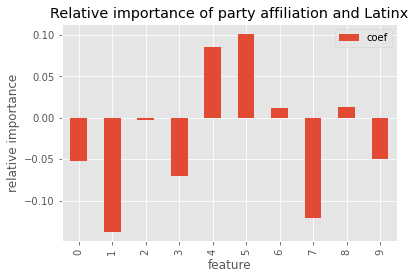

In [109]:
logreg_coef.plot(kind='bar', sort_columns=True).legend(
    loc='best', ncol=3)
plt.title("Relative importance of party affiliation and Latinx")
plt.xlabel("feature")
plt.ylabel("relative importance")
# plt.xticks(logreg_coef[['columns']]);

In [ ]:
def rmse(model):
    
    # calculate rmse scores
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    rmse_overfit = rmse_train < rmse_test
    
    # return rmse scores
    return f'for {model} rmse_train = {rmse_train}, and rmse_test = {rmse_test}.  Overfit = {rmse_overfit}'